# Session 3: Semantic Zooming
This notebook demonstrates a way to use a unique primitive, i.e., **semantic zooming**, in Gosling to reveal patterns across scales.


## What Is "Semantic Zooming"?

### _"Allowing objects to be represented differently at different scales."_ ([Cockburn, Karlson, Bederson. 2006](https://doi.org/10.1145/1456650.1456652))

A typical example of semantic zooming we find in the real world is Google Maps where you can see detailed information upon zooming in, such as store icons, names, streets.

<table>
<tr>
<td><img src="https://user-images.githubusercontent.com/9922882/175837927-cd43f7fc-c256-4e11-bf06-82d6486c4cd6.png"/></td>
<td><img src="https://user-images.githubusercontent.com/9922882/175837925-f0131aef-a6b0-427a-ac6b-6d60d52b67ac.png"/></td>
</tr>
</table>

_**Figure 1: Semantic Zooming in Google Maps.** The level of details is controlled by zoom levels. When zoomed in enough, more detailed information is displayed with icons, labels, etc._

## How To Use Semantic Zooming In Gosling?

Gosling enables you to dynamically change visual representations based on the zoom levels. The following Gosling variant track, for example, shows the individual variants in detail with a lollipop representation when zoomed in. The representation dynamically switches to stacked bar charts to show overall distributions when zoomed out.

<img src="https://user-images.githubusercontent.com/9922882/175838420-e3956bda-7132-4331-b2d0-cd8535221353.png"/>

_**Figure 2: Scalable variant track in the high zoom level.** This representation shows every variants with a lollipop representation. The narrow red rectangle on the chromosome 3 ideogram indicates the genomic location shown in the variant track._

<img src="https://user-images.githubusercontent.com/9922882/175944801-3d816dac-3875-45ea-a845-444d160bc597.png"/>

_**Figure 3: Scalable variant track that switches between two representations.** The lollipop representation is smoothly transitioned into stacked bar charts. The narrow red rectangle on the chromosome 3 ideogram indicates the genomic location shown in the variant track._

<img src="https://user-images.githubusercontent.com/9922882/175838417-63ff1a8f-ca51-4780-b395-32d2a549b129.png"/>

_**Figure 4: Scalable variant track in the high zoom level.** The lollipop representation is switched to stacked bar charts, showing overall distributions. The red rectangle on the chromosome 3 ideogram indicates the genomic location shown in the variant track._

So, how can you use semantic zooming in Gosling? You can do this by overlaying multiple tracks (here, the lollipop plot and the stacked bar chart), and determining when to show each track using a `visibility_*` property.

```python
# define two tracks
lollipop = gos.Track(data)...
stacked_bar_chart = gos.Track(data)...

# determine when to display each track
lollipop.visibility_lt( # lt refers to less than
    measure="zoomLevel",
    target="mark",
    threshold=100000 # one hundred thousand bases
)

stacked_bar_chartbars.visibility_gt( # gt refers to greater than
    measure="zoomLevel",
    target="mark",
    threshold=100000 # one hundred thousand bases
)

# overlay multiple tracks
gos.overlay(
  lollipop,
  stacked_bar_chart
)
```

More details about the options can be found at http://gosling-lang.org/docs/semantic-zoom

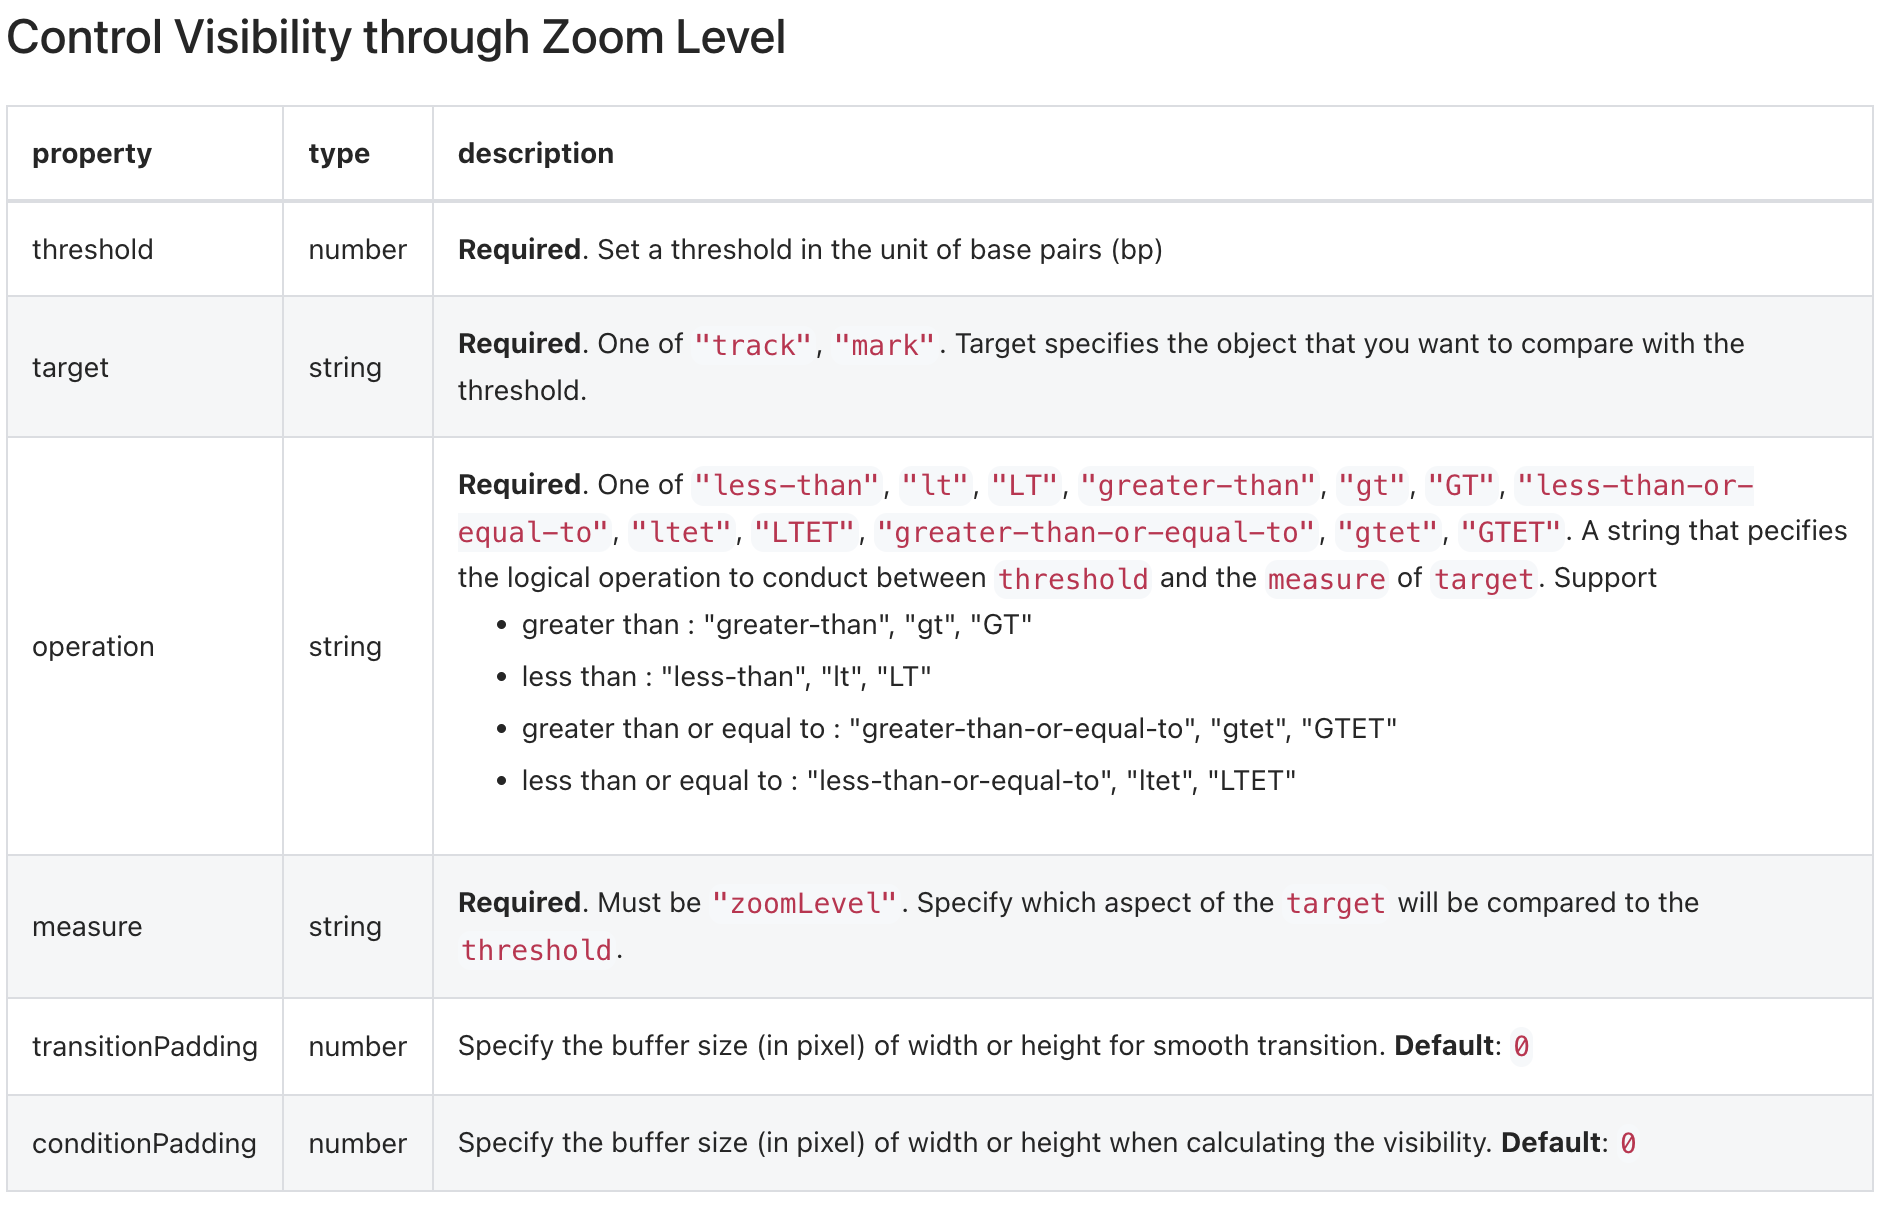

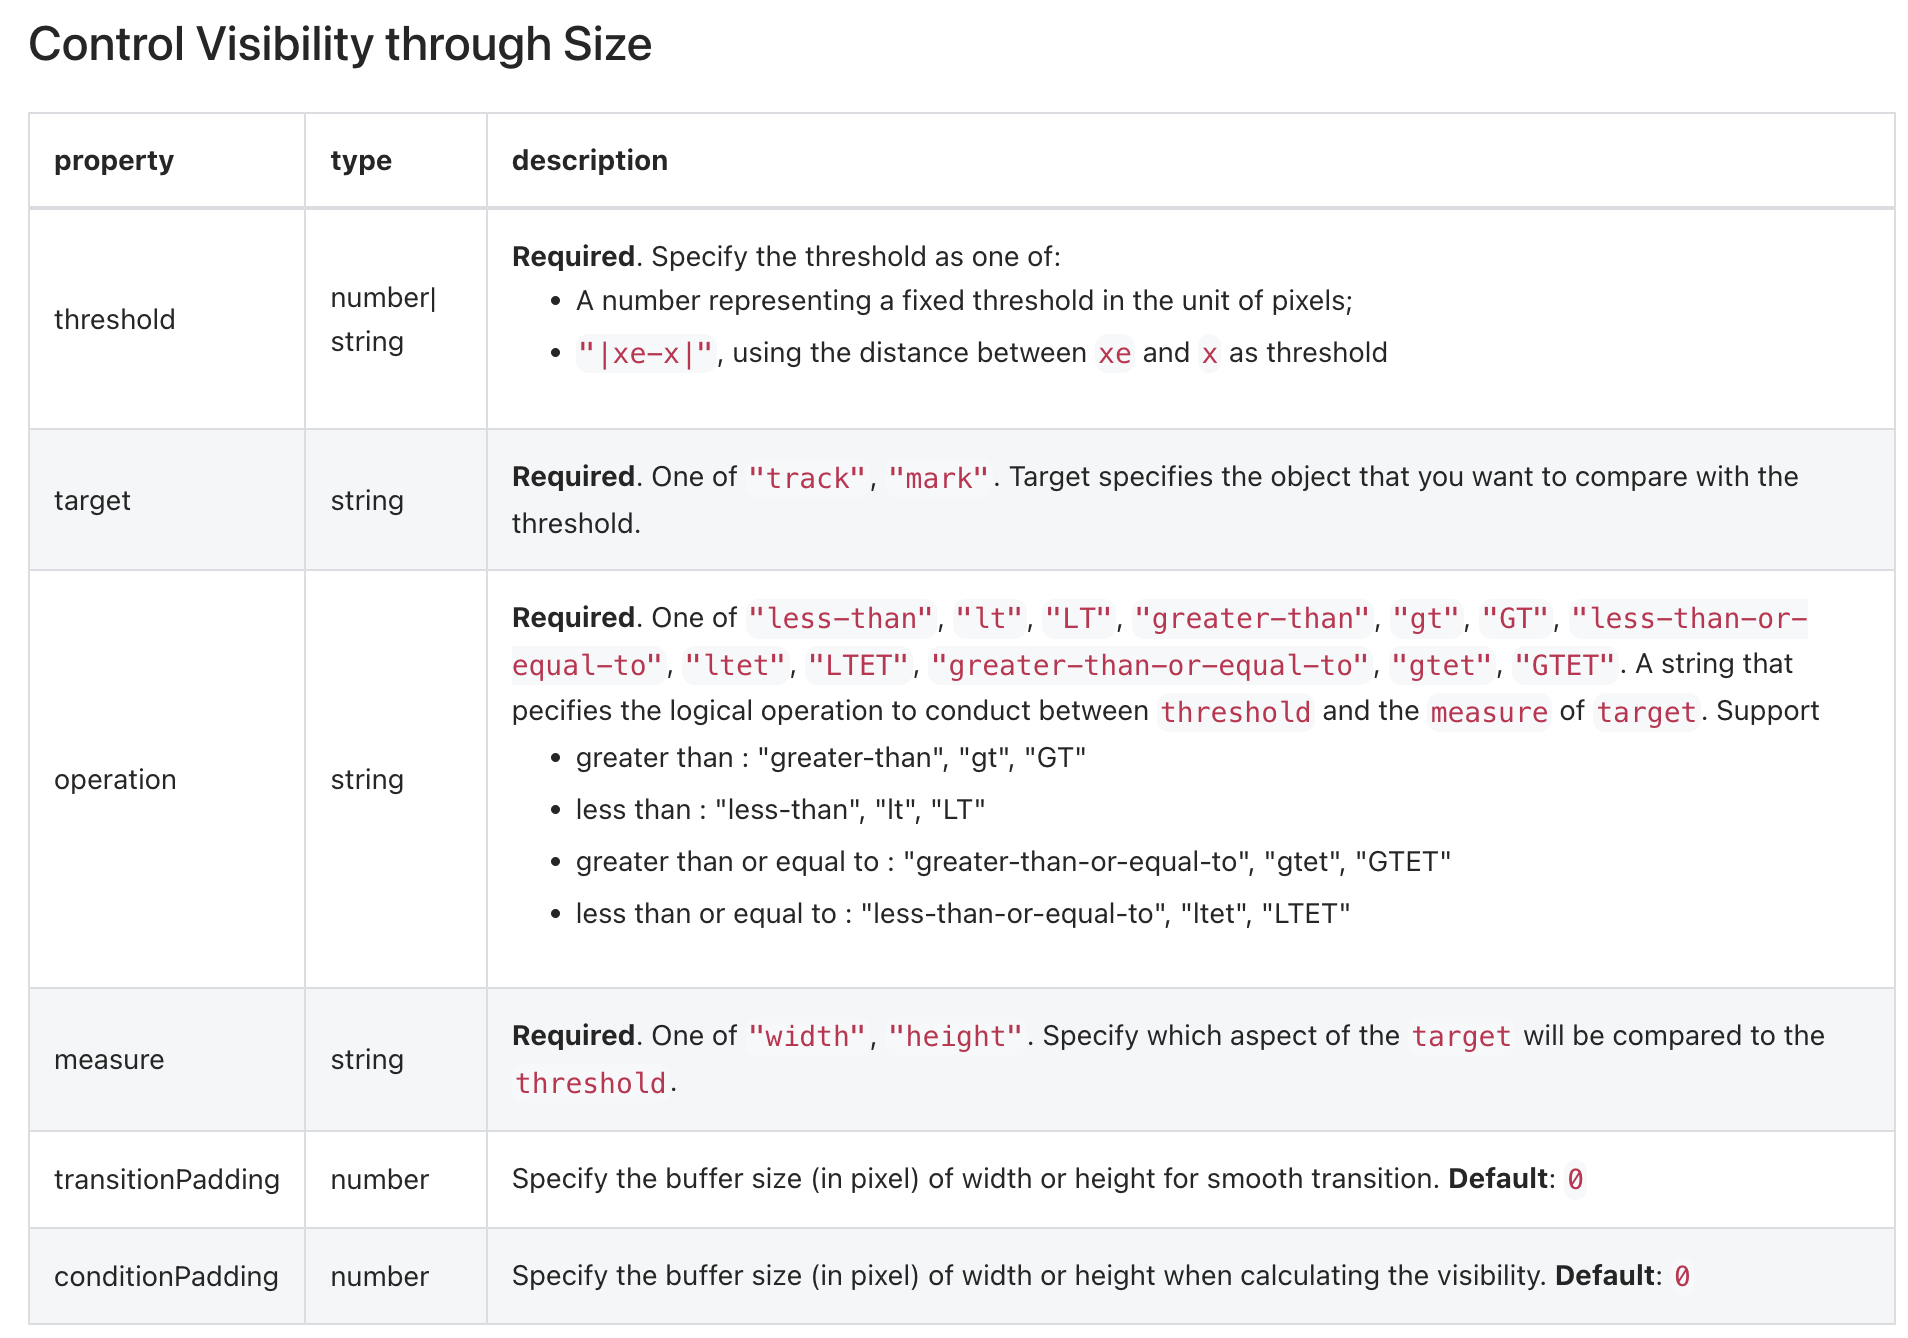

## 🧑‍💻 Exercises

Let's try semantic zooming in Gosling!

In [ ]:
!pip install gosling==0.0.9
import gosling as gos

### Exercise 1: Text Labels in Ideogram

Here is an ideogram track that we created in the previous session.

In [ ]:
# genomic position to display
xDomain = gos.GenomicDomain(chromosome="chr1", interval=[80000000, 180000000])

data = gos.csv(
    url="https://raw.githubusercontent.com/sehilyi/gemini-datasets/master/data/UCSC.HG38.Human.CytoBandIdeogram.bed",
    headerNames=['chrom', 'chromStart', 'chromEnd', 'name', 'stain'],
    chromosomeField="chrom",
    genomicFields=["chromStart", "chromEnd"],
    separator="\t"
)

arms = gos.Track(data).mark_rect().transform_filter_not(
    "stain", oneOf=["acen"]
).encode(
    # defines start and end of rectangle mark
    x=gos.X("chromStart:G", axis="top"),
    xe=gos.Xe("chromEnd:G"),
    # defines how to map Giemsa-stain factor to colors
    color=gos.Color(
        "stain:N", 
        domain=["gneg", "gpos25", "gpos50", "gpos75", "gpos100", "gvar"],
        range=["white", "#D9D9D9", "#979797", "#636363", "black", "#A0A0F2"]
    ),
    # customize the style of the visual marks.
    size=gos.value(20),
    stroke=gos.value("gray"),
    strokeWidth=gos.value(0.5)
)

centromere_base = gos.Track(data).encode(
    x=gos.X("chromStart:G"),
    xe="chromEnd:G",
    color=gos.value('red'),
    size=gos.value(20),
).transform_filter(
    "stain", oneOf=["acen"]
)

centromere_1 = centromere_base.mark_triangleLeft().transform_filter(
    "name", include="p"
)

centromere_2 = centromere_base.mark_triangleRight().transform_filter(
    "name", include="q"
)

ideogram = gos.overlay(arms, centromere_1, centromere_2).properties(xDomain=xDomain)

ideogram

Now, we want to display more detailed information by adding text labels for each region (i.e., `name`). Let's do this in a simple way.

In [ ]:
arm_labels = arms.mark_text().encode(
    # defines the text contents
    text="name:N",
    # defines the text colors
    color=gos.Color("stain:N",
        domain=["gneg", "gpos25", "gpos50", "gpos75", "gpos100", "gvar"],
        range=["black", "#636363", "black", "#D9D9D9", "white", "black"],
    ),
    # defines the font size in px
    size=gos.value(10),
    # defines the outline width and color of text labels
    strokeWidth=gos.value(0),
    stroke=gos.value('black')
)

ideogram = gos.overlay(
    arms, 
    arm_labels, # newly added track
    centromere_1, 
    centromere_2
).properties(xDomain=xDomain)

ideogram

This seems to work fine. But, what if you zoom out to see an entire chromosome?

In [ ]:
ideogram.properties(xDomain=gos.GenomicDomain(chromosome="chr1"))

It is so cluttered that you cannot read labels! 

How to address this and make visualization more readable? You can use semantic zooming! 

Let's modify the code a little bit.

<!-- Due to the scale of genomes, such issues are quite common when creating genomics visualizations. This is a reason why we enabled an advanced feature of Gosling, **semantic zooming**. -->



In [ ]:
# determines when to display individual text labels
arm_labels = arm_labels.visibility_lt(
    target='mark', # control visibility of `mark` or entire `track`?
    measure='width', # measurement to compare with threshold
    threshold='|xe-x|', # this refers to the assigned width of a text label (i.e., same as the size of `rect`) 
    # transitionPadding=4 # padding in px to enable smooth transition using transparency
)

ideogram = gos.overlay(
    arms, 
    arm_labels, # track with semantic zooming
    centromere_1, 
    centromere_2
).properties(xDomain=gos.GenomicDomain(chromosome='chr1'))

ideogram

Now, the visualization only displays text labels that are within the each rectangle.

You can zoom in and out using your mouse wheel to see how text labels are dynamically shown.

This is perhaps the simplest example for using semantic zooming in Gosling, and there are many cool ways of using it!

### Exercise 2: Scalable Sequence Track

Using the similar way, you can make you sequence track scalable, showing both distributions in low resolutions and individual bases in highest resolutions.

In [ ]:
data = gos.multivec(
    url="https://server.gosling-lang.org/api/v1/tileset_info/?d=sequence-multivec",
    row="base",
    column="position",
    value="count",
    categories=["A", "T", "G", "C"]
)

bar = gos.Track(data).mark_bar().encode(
    x="position:G",
    y=gos.Y("count:Q", axis="none"),
    color=gos.Color("base:N", domain=["A", "T", "G", "C"], legend=True)
)

text = gos.Track(data).mark_text().encode(
    x="start:G",
    xe="end:G",
    size=gos.value(24),
    color=gos.value("white"),
    text="base:N",
).transform_filter_not("count", oneOf=[0])

# Exercise: Uncomment the following lines and fill in the properties
# determines visibility of the text labels
text = text.visibility_lt(
    # add here
    # target=?,
    # measure=?,
    # threshold=?,
    # transitionPadding=?
)

sequence = gos.overlay(bar, text).properties(
    xDomain=gos.GenomicDomain(interval=[1000000, 1000010])
)

sequence

### Exercise 3: Scalable Variant Track

Previous examples focused only on text lables, but semantic zooming can be applied to any marks supported in Gosling. Let's look at the following variant track.

The data sources for this section are derived from the VCF at:

- https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz

The two derived ClinVar datasets are:

- `clinvar.bed.beddb` - the individual variants and classifications in multires bed-like format

- `density.multires.mv5` - a precomputed, multiresolution aggregation of variant classifications genome-wide

Our dataset includes sevaral categories of clinical relevance, and we make a mapping of each category to a color for our visualization.

In [ ]:
categories = [
    "Benign", 
    "Benign/Likely_benign", 
    "Likely_benign", 
    "Uncertain_significance",
    "Likely_pathogenic", 
    "Pathogenic/Likely_pathogenic",
    "Pathogenic",
]

colors = ["#5A9F8C", "#5A9F8C", "#029F73", "gray", "#CB96B3", "#CB71A3", "#CB3B8C"]

#### (1) Lolipop represenation of individual variants

First we encode the individual variants using a lolipop representation, which layers `bar` and `point` marks.

In [ ]:
# define our data source 
variants = gos.beddb(
    url="https://server.gosling-lang.org/api/v1/tileset_info/?d=clinvar-beddb",
    genomicFields=[{"index": 1, "name": "start"}, {"index": 2, "name": "end"}],
    valueFields=[{"index": 7, "name": "significance", "type": "nominal"}],
)

# some constants
lollipop_height = 200
dy = lollipop_height / len(categories) / 2

strips = gos.Track(variants).mark_bar().encode(
    x="start:G",
    y=gos.Y(
        "significance:N",
        domain=categories,
        range=[lollipop_height + dy, dy],
        baseline="Uncertain_significance",
    ),
    ye=gos.value(lollipop_height/2),
    size=gos.value(1),
    color=gos.value("lightgray"),
    stroke=gos.value("lightgray"),
    strokeWidth=gos.value(1),
    opacity=gos.value(0.3),
).transform_filter('significance', oneOf=categories).properties(height=lollipop_height)

# just the "handles" of the lolipop
strips.view()

In [ ]:
# just the "tops" of the lolipop
points = gos.Track(variants).mark_point().encode(
    x="start:G",
    color=gos.Color("significance:N", domain=categories, range=colors),
    row=gos.Row("significance:N", domain=categories),
    size=gos.value(7),
    opacity=gos.value(0.8),
).properties(height=lollipop_height)

points.view()

In [ ]:
# combined
gos.overlay(strips, points)

#### (2) Density representation of variant classifications

Next we use a `bar` encoding to display the multiresolution aggregate density of each variant classification.

In [ ]:
density = gos.multivec(
    url="https://server.gosling-lang.org/api/v1/tileset_info/?d=clinvar-multivec",
    row="significance",
    column="position",
    value="count",
    categories=categories,
    binSize=4,
)

bars = gos.Track(density).mark_bar().encode(
    x="start:G",
    xe="end:G",
    y=gos.Y("count:Q", axis="none"),
    color=gos.Color("significance:N", domain=categories, range=colors, legend=True)
)

bars.view().properties(xDomain=gos.GenomicDomain(chromosome="chr17"))

#### (3) Combined semantic zoom track

Now that we have defined our visualizations in isolation, we can combine them into a single view that switches the visual enocoding when zooming. We the semantic zoom properties with `visibility_lt` and `visibility_gt` options.

In [ ]:
lolipop = gos.overlay(
    strips,
    # show when zoom level is less than 100,000 bases
    # .visibility_?(
    #     measure=?,
    #     target="mark",
    #     threshold=?,
    #     transitionPadding=?,
    # ),
    points,
    # show when zoom level is less than 1,000,000 bases
    # .visibility_?(
    #     measure=?,
    #     target="mark",
    #     threshold=?,
    #     transitionPadding=?,
    # ),
    bars,
    # show when zoom level is less than 500,000 bases
    # .visibility_?(
    #     measure=?,
    #     target="mark",
    #     threshold=?,
    #     transitionPadding=?,
    # )
)
lolipop.properties(
    xDomain=gos.GenomicDomain(chromosome="17"),
)

## Additional Resources
- Documentation: http://gosling-lang.org/docs/semantic-zoom
- Sequence example
  - https://gosling.js.org/?example=SEQUENCE
  - https://gosling-lang.github.io/gos/gallery/multiscale_sequence.html
- Lollipop example
  - https://gosling.js.org/?example=SEMANTIC_ZOOM
  - https://gosling-lang.github.io/gos/gallery/multiscale_lollipop_plot.html